# Capstone Project: Predicting Speeding from Open Street Maps and Telematics Data

##### Professional Certificate in Machine Learning and Artificial Intelligence
##### Jeremy Stairs
##### June 2024

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score, precision_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import warnings
warnings.filterwarnings("ignore")

## 1. Business Understanding

### Executive Summary

This project uses Open Street Maps (OSM) data with fleet vehicle data to predict if a driver is speeding in each driving report. Using OSM data, the cost per report will be much lower than the paid mapping services. Unfortunately, OSM is far from complete. Many requests are returned with no speed limit. It's difficult to predict the speed limit in a specific location using just OSM data. However, we might be able to use OSM data along with the known vehicle speed to predict if the driver is speeding. It's unlikelt that the error will be low enough to reliably send an alert to the user. Still, this prediction can idicate potential speeding. If speeding is likely, we can perform more accurate and costly speed limit queries. Ultimately, it's important that we catch each instance of speeding to ensure driver safety for all of our customers.

### Rationale

As a fleet telematics company, our customers reqire alerts when drivers are speeding. Vehicle speed is included in each vehicle report. However, there are few complete speed limit databases. None are free. The Open Street Map project includes speed limits, but this only covers about 12% of its roads. Until the crowd-sourced database is complete, a model for predicting when a driver is speeding would allow us to reduce costs while still providing our customers with alerts needed to ensure fleet vehicles are driven safely. 

### Research Question

Can telematics data and Open Street maps data be used to determine if a driver is speeding?

Note:
My original question asked if the speed limit could be predicted from OSM data. Early testing showed scores under 0.3. This was likely due to the target being multilabel with over 10 different labels. I decided to refoucus the question to determine when vehicles were driven over the posted speed limit. Thas has a simiple yes/no target and is very relavent to our company's speed limit alert serivce.

## 2. Data Understanding

### Data Sources

This project has two data sources:

- Fleet telematics data
- Open Street Maps (OSM) tag data

Speed limits and associated mapping data are publicly available from the Open Street Map (OSM) project. There are mapping files with varying levels of granularity (continent, country, state). The files can be uncompressed and imported to a PostgreSQL server. The compressed mapping files for the entire world are about 100 GB which require about 1TB of database space. We have a server with full mapping data for the continental US. 

OSM Wiki: https://wiki.openstreetmap.orgLinks to an external site.

OSM mapping files: https://download.geofabrik.de/

Our units in the field report telematics data periodically while moving. This data is combined with data from OSM based on the vehicle location. I extracted data for several days of reporting when both vehicle speed and OSM speed limit were included. The data was unaltered expect for the 'speeding' column which was derived from the posted speed limit and the vehicle speed.

In [2]:
speeding = pd.read_csv('data/speeding.csv', low_memory=False)

In [3]:
speeding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196472 entries, 0 to 196471
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   normalizedSpeed  196430 non-null  float64
 1   lanes            184500 non-null  object 
 2   oneway           170363 non-null  object 
 3   surface          121077 non-null  object 
 4   hgv              105231 non-null  object 
 5   foot             55820 non-null   object 
 6   horse            34329 non-null   object 
 7   bicycle          90839 non-null   object 
 8   speeding         196472 non-null  object 
dtypes: float64(1), object(8)
memory usage: 13.5+ MB


The dataset contains eight features and one target:
- normalizedSpeed - vehicle speed normalized to miles per hour
- lanes - number of lanes traveling in the same direction
- oneway - indicates if the OSM way only allows travel in one directions, possible values: yes, no, reversible, alternating
- surface - the phyical surface of the OSM way
- hgv - indicates conditions for heavy good vehicles
- foot - indicates if pedestrian foot traffic is allowed
- horse - indicates if equestrians are allowed
- bicycle - indicates if bicyclists are allowed
- speeding - target - if 'yes', the vehicle speed was greater than posted speed limit, otherwise 'no'

## 3. Data Perparation

In [4]:
speeding.head(10)

,normalizedSpeed,lanes,oneway,surface,hgv,foot,horse,bicycle,speeding
0,61.0,2,NaN,asphalt,NaN,NaN,NaN,NaN,Yes
1,16.0,2,NaN,asphalt,NaN,NaN,NaN,NaN,No
2,50.0,3,yes,NaN,designated,no,no,no,No
3,19.0,2,NaN,asphalt,NaN,NaN,NaN,NaN,No
4,0.0,2,yes,asphalt,NaN,NaN,NaN,NaN,No
5,0.0,2,no,asphalt,NaN,NaN,NaN,NaN,No
6,5.0,2,no,asphalt,NaN,NaN,NaN,NaN,No
7,66.0,4,yes,NaN,designated,no,no,no,Yes
8,56.0,3,yes,NaN,designated,no,no,no,No
9,23.0,3,yes,NaN,designated,no,no,no,No


OSM tags are sparsly populated. Unfortunately, this means that the dataset has many NaN vlaues. Before analysis, records with null values and duplicate records are removed.

In [5]:
speeding.dropna(inplace=True)
print('Row count after null values have been removed: ', speeding.shape[0])

Row count after null values have been removed:  17662


Many vheicles travel on regular routes or perform work in a limited territory. The dataset originally had a large number of duplicates. These were previously removed to reduce the file size.

Reset the dataframe index

In [6]:
speeding.reset_index(drop=True)

,normalizedSpeed,lanes,oneway,surface,hgv,foot,horse,bicycle,speeding
0,63.000000,3,yes,asphalt,designated,no,no,no,Yes
1,45.000000,2,yes,asphalt,designated,no,no,no,No
2,32.000000,3,yes,asphalt,designated,no,no,no,No
3,40.000000,3,yes,asphalt,designated,no,no,no,No
4,47.000000,3,yes,asphalt,designated,no,no,no,Yes
...,...,...,...,...,...,...,...,...,...
17657,9.000000,3,yes,concrete,designated,no,no,yes,No
17658,23.245489,5,yes,asphalt,designated,no,no,no,No
17659,27.000000,1,yes,asphalt,designated,no,no,no,Yes
17660,69.737089,4,yes,concrete,designated,no,no,no,No


In [7]:
speeding.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17662 entries, 53 to 196462
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   normalizedSpeed  17662 non-null  float64
 1   lanes            17662 non-null  object 
 2   oneway           17662 non-null  object 
 3   surface          17662 non-null  object 
 4   hgv              17662 non-null  object 
 5   foot             17662 non-null  object 
 6   horse            17662 non-null  object 
 7   bicycle          17662 non-null  object 
 8   speeding         17662 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.3+ MB


### Feature examination

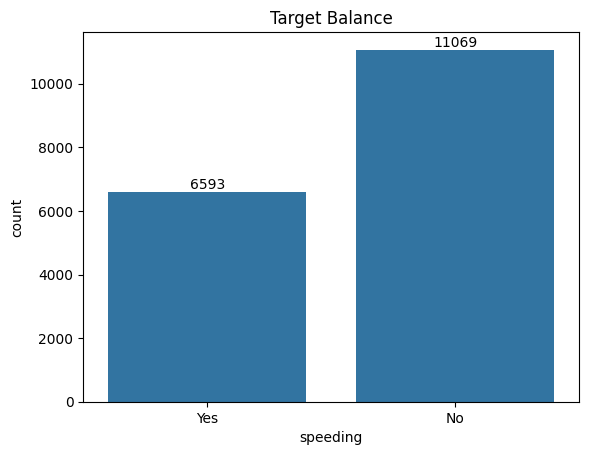

In [8]:
ax = sns.countplot(speeding, x='speeding')
ax.set_title('Target Balance')
ax.bar_label(ax.containers[0])
ax.figure.savefig("images/target_balance.png", bbox_inches='tight');

The target is imbalanced with a ratio of nearly 2 to 1 favoring 'No'.

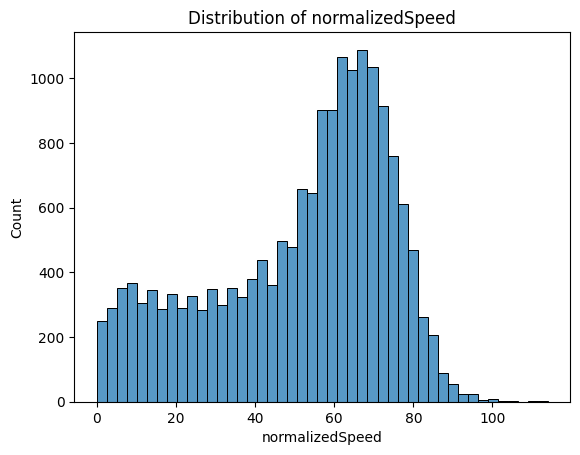

In [9]:
sns.histplot(data=speeding, x='normalizedSpeed').set_title('Distribution of normalizedSpeed');

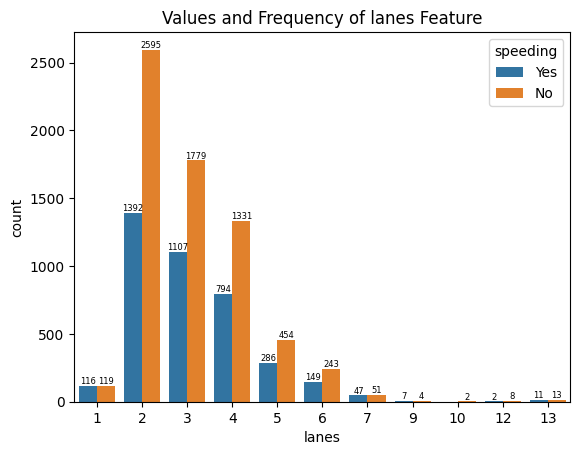

In [10]:
ax = sns.countplot(speeding, x="lanes", hue='speeding', order=sorted(speeding['lanes'].astype('float').astype('int').unique().tolist(), key=int))
ax.set_title('Values and Frequency of lanes Feature')
ax.bar_label(ax.containers[0], fontsize=6)
ax.bar_label(ax.containers[1], fontsize=6);

The feature 'lanes' appears to contain meaningful information. Some labels show an imbalence similar to the target, but the balance between 'yes' and 'no' gets more even for roads with more lanes. This could be due to a tendancy to speed on wider roads with more opportunity to safely pass.

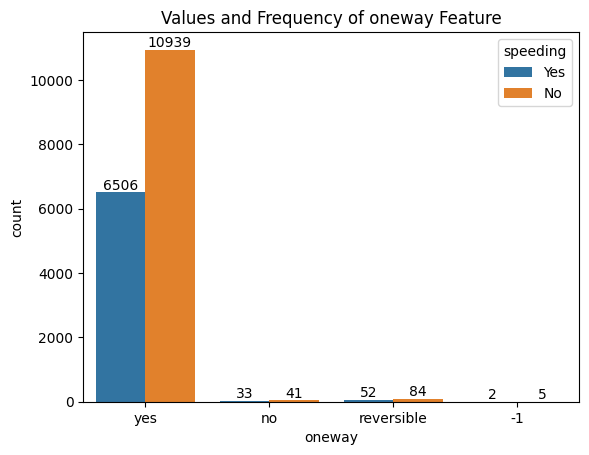

In [11]:
ax = sns.countplot(speeding, x="oneway", hue='speeding')
ax.set_title('Values and Frequency of oneway Feature')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

The value '-1' is equivalent to 'reversible'. The records with oneway='-1' will be converted to oneway='reversible'.

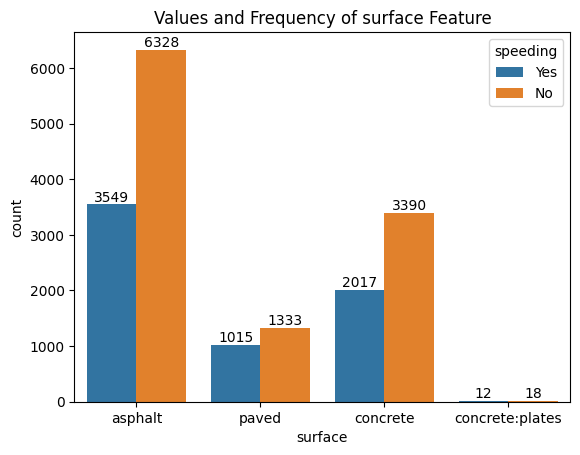

In [12]:
ax = sns.countplot(speeding, x="surface", hue='speeding')
ax.set_title('Values and Frequency of surface Feature')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

The feature 'surface' shows a tendancy to speed on paved and concrete roads.

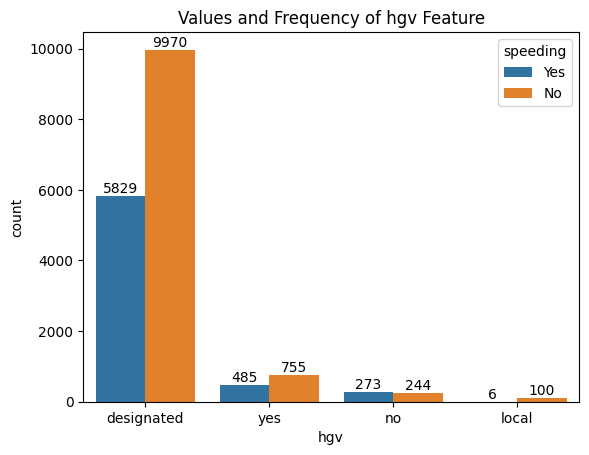

In [13]:
ax = sns.countplot(speeding, x="hgv", hue='speeding')
ax.set_title('Values and Frequency of hgv Feature')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

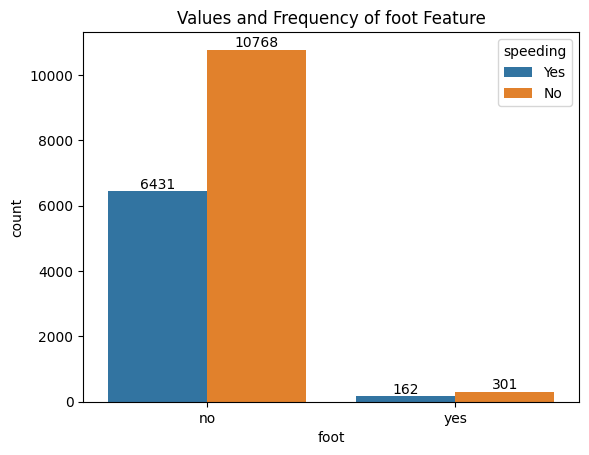

In [14]:
ax = sns.countplot(speeding, x="foot", hue='speeding')
ax.set_title('Values and Frequency of foot Feature')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

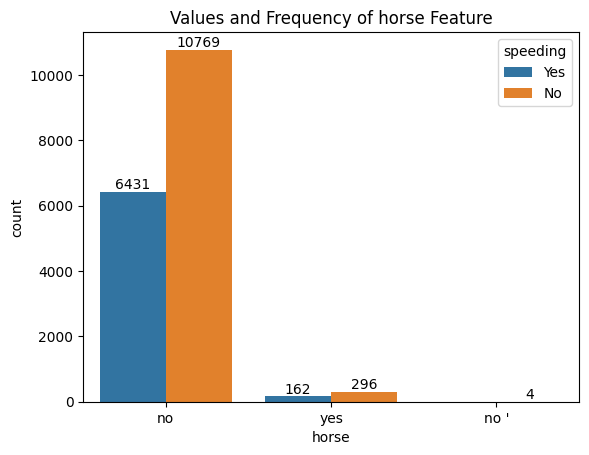

In [15]:
ax = sns.countplot(speeding, x="horse", hue='speeding')
ax.set_title('Values and Frequency of horse Feature')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

The value 'no '' is likely a typo. It will be converted to 'no'.

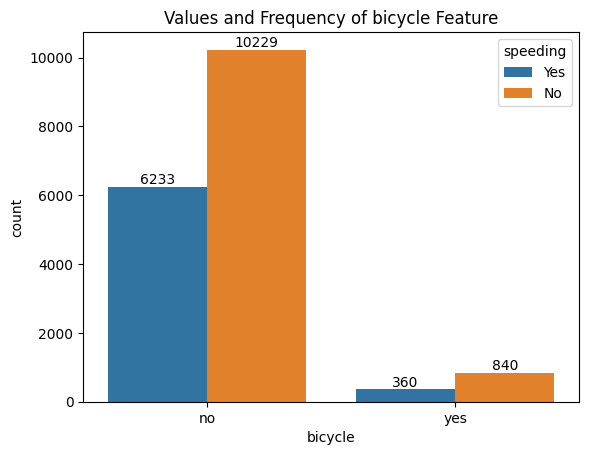

In [16]:
ax = sns.countplot(speeding, x="bicycle", hue='speeding')
ax.set_title('Values and Frequency of bicycle Feature')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

The features 'foot', 'horse', and 'bicycle' are all yes/no features which are all imbalanced favoring 'no'. However, the target balance for each feature show that they could contain meaningful informations as a group.

Data preparation:
- 'lanes' will be cast from an object to a numerical feature
- 'oneway' will have the values '-1' changed to 'reversible'
- 'horse' will have the value 'no '' converted to 'no'
- the features 'oneway', 'surface', and 'hgv' will be converted to numerical features using one-hot encoding
- the features 'foot', 'horse', and 'bicycle' will be converted to numerical features using binary encoding

### Data Cleaning

Convert the 'lanes' feature to numeric

In [17]:
speeding['lanes'] = speeding['lanes'].astype('float').astype('int32')

Remove odd values from the features 'oneway' and 'horse'

In [18]:
speeding.loc[speeding['oneway'] == '-1', 'oneway'] = 'reversible'

In [19]:
speeding.loc[speeding['horse'] == "no '", 'horse'] = 'no'

Change the fields 'surface', 'hgv', and 'oneway' to numberical fields using one hot encoding

In [20]:
speeding = pd.get_dummies(speeding, columns = ['surface', 'hgv', 'oneway'], dtype=int)

Change the fields 'foot', 'horse', and 'bicycle' to numberical fields using binary values

In [21]:
speeding['foot'] = pd.Series(np.where(speeding.foot.values == 'yes', 1, 0), speeding.index)

In [22]:
speeding['horse'] = pd.Series(np.where(speeding.horse.values == 'yes', 1, 0), speeding.index)

In [23]:
speeding['bicycle'] = pd.Series(np.where(speeding.bicycle.values == 'yes', 1, 0), speeding.index)

In [24]:
speeding.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17662 entries, 53 to 196462
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   normalizedSpeed          17662 non-null  float64
 1   lanes                    17662 non-null  int32  
 2   foot                     17662 non-null  int64  
 3   horse                    17662 non-null  int64  
 4   bicycle                  17662 non-null  int64  
 5   speeding                 17662 non-null  object 
 6   surface_asphalt          17662 non-null  int64  
 7   surface_concrete         17662 non-null  int64  
 8   surface_concrete:plates  17662 non-null  int64  
 9   surface_paved            17662 non-null  int64  
 10  hgv_designated           17662 non-null  int64  
 11  hgv_local                17662 non-null  int64  
 12  hgv_no                   17662 non-null  int64  
 13  hgv_yes                  17662 non-null  int64  
 14  oneway_no                

#### Separating the target and features

In [25]:
y = speeding['speeding']
X = speeding.drop('speeding', axis=1)
y

53        Yes
88         No
104        No
105        No
106       Yes
         ... 
196361     No
196370     No
196431    Yes
196453     No
196462     No
Name: speeding, Length: 17662, dtype: object

#### Spliting the data into training and test sets

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## 4. Data Modeling

### Methodology

This project will compare four classifiers:
- Logistic Regression
- K-Nearest Neighbors
- Decision Tree
- Support Vector Machine

A baseline will be set using LogisticRegression with default settings. Further modeling will use the classifiers above with default parameters. Grid search will be used to tune hyperparameters.

#### Selecting evaluation metrics

The target of our data set is imbalanced nearly 2 to 1. This imbalance makes accuracy a bad evaluation metric. We will consider the metrics precision and recall. Precision minimizes false positives.  This will favor models that catch _some_ speeders, but is unlikely to classify a non-speeder incorrectly. Models with high recall scores will be more likely to catch _all_ speeder, while some non-speeders will be incorrectly classified as speeding. We will measure both metrics for the baseline and default models.

#### Establish baseline scores

Using LogisticRegression

In [27]:
simple_lgr_start_time_ms = round(time.time() * 1000)
simple_lgr_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('lgr', LogisticRegression(random_state=42))]).fit(X_train, y_train)
simple_lgr_end_time_ms = round(time.time() * 1000)

In [28]:
baseline_train_time = simple_lgr_end_time_ms - simple_lgr_start_time_ms
baseline_ytrain_pred = simple_lgr_pipe.predict(X_train)
baseline_ytest_pred = simple_lgr_pipe.predict(X_test)
baseline_train_precision = round(precision_score(y_train, baseline_ytrain_pred, pos_label='Yes'), 4)
baseline_test_precision = round(precision_score(y_test, baseline_ytest_pred, pos_label='Yes'), 4)
baseline_train_recall = round(recall_score(y_train, baseline_ytrain_pred, pos_label='Yes'), 4)
baseline_test_recall = round(recall_score(y_test, baseline_ytest_pred, pos_label='Yes'), 4)

Basline scores

In [29]:
print('Simple Model: Train Time is', baseline_train_time, 'ms,', \
      'Train Precision is', round(baseline_train_precision, 4), ',', \
      'Test Precision is', round(baseline_test_precision, 4), ',', \
      'Train Recall is', round(baseline_train_recall, 4), ',', \
      'Test Recall is', round(baseline_test_recall, 4))

Simple Model: Train Time is 29 ms, Train Precision is 0.7047 , Test Precision is 0.6849 , Train Recall is 0.7267 , Test Recall is 0.7498


#### Support functions to get time and score metrics

In [30]:
def getMetrics(model, start_time_ms, end_time_ms):
    train_time = round(end_time_ms - start_time_ms)
    ytrain_pred = model.predict(X_train)
    ytest_pred = model.predict(X_test)
    train_precision = round(precision_score(y_train, ytrain_pred, pos_label='Yes'), 4)
    test_precision = round(precision_score(y_test, ytest_pred, pos_label='Yes'), 4)
    train_recall = round(recall_score(y_train, ytrain_pred, pos_label='Yes'), 4)
    test_recall = round(recall_score(y_test, ytest_pred, pos_label='Yes'), 4)
    return [train_time, train_precision, test_precision, train_recall, test_recall]

In [31]:
def printMetrics(train_time, train_precision, test_precision, train_recall, test_recall):
    print('Train Time is', train_time, 'ms,', \
      'Train Precision is', train_precision, ',', \
      'Test Precision is', test_precision, ',', \
      'Train Recall is', train_recall, ',', \
      'Test Recall is', test_recall)

#### Modeling with default values

Logistic Regression

In [32]:
lgr_start_time_ms = round(time.time() * 1000)
default_lgr_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('lgr', LogisticRegression(random_state=42))]).fit(X_train, y_train)
lgr_end_time_ms = round(time.time() * 1000)

In [33]:
default_lgr_metrics = getMetrics(default_lgr_pipe, lgr_start_time_ms, lgr_end_time_ms)
print('Logistic Regression:')
printMetrics(*default_lgr_metrics)

Logistic Regression:
Train Time is 16 ms, Train Precision is 0.7047 , Test Precision is 0.6849 , Train Recall is 0.7267 , Test Recall is 0.7498


K-Nearest Neighbor

In [34]:
knn_start_time_ms = round(time.time() * 1000) 
default_knn_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier())]).fit(X_train, y_train)
knn_end_time_ms = round(time.time() * 1000)

In [35]:
default_knn_metrics = getMetrics(default_knn_pipe, knn_start_time_ms, knn_end_time_ms)
print('K-Neighbors:')
printMetrics(*default_knn_metrics)

K-Neighbors:
Train Time is 8 ms, Train Precision is 0.7961 , Test Precision is 0.6555 , Train Recall is 0.7683 , Test Recall is 0.6646


Decision Tree

In [36]:
dtc_start_time_ms = round(time.time() * 1000) 
default_dtc = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
dtc_end_time_ms = round(time.time() * 1000)

In [37]:
default_dtc_metrics = getMetrics(default_dtc, dtc_start_time_ms, dtc_end_time_ms)
print('Decision Tree: Train Time is')
printMetrics(*default_dtc_metrics)

Decision Tree: Train Time is
Train Time is 19 ms, Train Precision is 0.9133 , Test Precision is 0.5964 , Train Recall is 0.713 , Test Recall is 0.5414


Support Vector Classifier

In [38]:
svc_start_time_ms = round(time.time() * 1000) 
default_svc_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC(random_state=42))]).fit(X_train, y_train)
svc_end_time_ms = round(time.time() * 1000)

In [39]:
default_svc_metrics = getMetrics(default_svc_pipe, svc_start_time_ms, svc_end_time_ms)
print('Support Vector Machine:')
printMetrics(*default_svc_metrics)

Support Vector Machine:
Train Time is 1464 ms, Train Precision is 0.725 , Test Precision is 0.6977 , Train Recall is 0.7074 , Test Recall is 0.7334


Default Model Results

In [40]:
metric_columns = ['Train Time (ms)', 'Train Precision', 'Test Precision', 'Train Recall', 'Test Recall']
default_results = pd.DataFrame({ 
        'Logistic Regression': pd.Series(default_lgr_metrics, index=metric_columns), 
        'K-Nearest Neighbors': pd.Series(default_knn_metrics, index=metric_columns), 
        'Decision Tree': pd.Series(default_dtc_metrics, index=metric_columns),
        'Support Vector Machine': pd.Series(default_svc_metrics, index=metric_columns)}).T
default_results

,Train Time (ms),Train Precision,Test Precision,Train Recall,Test Recall
Logistic Regression,16.0,0.7047,0.6849,0.7267,0.7498
K-Nearest Neighbors,8.0,0.7961,0.6555,0.7683,0.6646
Decision Tree,19.0,0.9133,0.5964,0.7130,0.5414
Support Vector Machine,1464.0,0.7250,0.6977,0.7074,0.7334


Logistic regression had a higher recall score. SVC had a higher precision score, but the train time for SVC was much longer.

#### Modeling with Grid Search

Considering the test scores for the default models, it's unlikely that the models can be used as the only source to determine if the vehicle was speeding. However, we could use model to find potential speeding vehicles. We will use recall to evaluate the models. This will make the models more likely to find all speeding vehciles. Readings that are classified as speeding can be sent to a more accurate, but more expensive, speed limit service.

Custom scorer

In [41]:
recall_scorer = make_scorer(recall_score, pos_label='Yes')

Support funtion to print time and recall scores

In [42]:
def printTunedMetrics(train_time, train_score, test_score):
    print('Train Time is', train_time, 'ms,', \
      'Train Recall is', train_score, ',', \
      'Test Recall is', test_score)

Logistic Regression

In [43]:
params = [
  {'lgr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'lgr__penalty': ['l1', 'l2'], 'lgr__solver': ['liblinear']},
  {'lgr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'lgr__penalty': ['l2'], 'lgr__solver': ['lbfgs','newton-cg', 'newton-cholesky']},
 ]
tuned_lgr_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('lgr', LogisticRegression(random_state=42))])
tuned_lgr = GridSearchCV(tuned_lgr_pipe, params, cv=5, scoring=recall_scorer).fit(X_train, y_train)

In [44]:
print('Best parameters:')
print(tuned_lgr.best_params_)

Best parameters:
{'lgr__C': 0.001, 'lgr__penalty': 'l1', 'lgr__solver': 'liblinear'}


In [45]:
tuned_lgr_start_time_ms = round(time.time() * 1000) 
tuned_lgr.best_estimator_.fit(X_train, y_train)
tuned_lgr_end_time_ms = round(time.time() * 1000)
lgr_y_pred = tuned_lgr.predict(X_test)

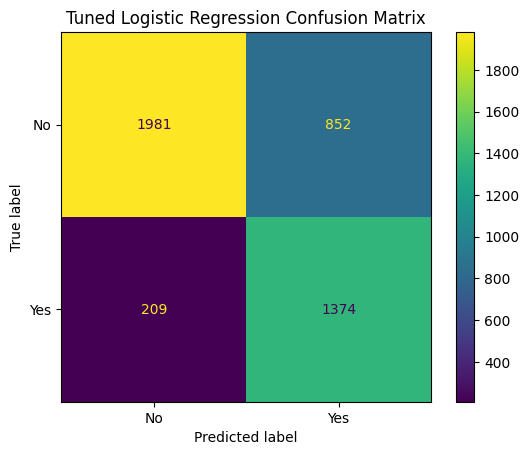

In [46]:
lgr_cm = confusion_matrix(y_test, lgr_y_pred)

lgr_cmd = ConfusionMatrixDisplay(confusion_matrix=lgr_cm, display_labels=tuned_lgr.classes_)
fig = lgr_cmd.plot().figure_
plt.title('Tuned Logistic Regression Confusion Matrix')
plt.show()
fig.tight_layout(rect=(0,.05,1,1)) 

In [47]:
tuned_lgr_train_time = round(tuned_lgr_end_time_ms - tuned_lgr_start_time_ms)
tuned_lgr_train_score = round(tuned_lgr.score(X_train, y_train), 4)
tuned_lgr_test_score = round(recall_score(y_test, lgr_y_pred, pos_label='Yes'), 4)
printTunedMetrics(tuned_lgr_train_time, tuned_lgr_train_score, tuned_lgr_test_score)

Train Time is 14 ms, Train Recall is 0.8473 , Test Recall is 0.868


K-Nearest Neighbor

In [48]:
params = {'knn__n_neighbors': [1, 3, 5, 7, 9, 11, 15, 21, 25],
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'minkowski', 'manhattan']
}
tuned_knn_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsClassifier())])
tuned_knn = GridSearchCV(tuned_knn_pipe, params, cv=5, scoring=recall_scorer).fit(X_train, y_train)

In [49]:
print('Best parameters:')
print(tuned_knn.best_params_)

Best parameters:
{'knn__metric': 'euclidean', 'knn__n_neighbors': 21, 'knn__weights': 'uniform'}


In [50]:
tuned_knn_start_time_ms = round(time.time() * 1000) 
tuned_knn.best_estimator_.fit(X_train, y_train)
tuned_knn_end_time_ms = round(time.time() * 1000)
knn_y_pred = tuned_knn.predict(X_test)

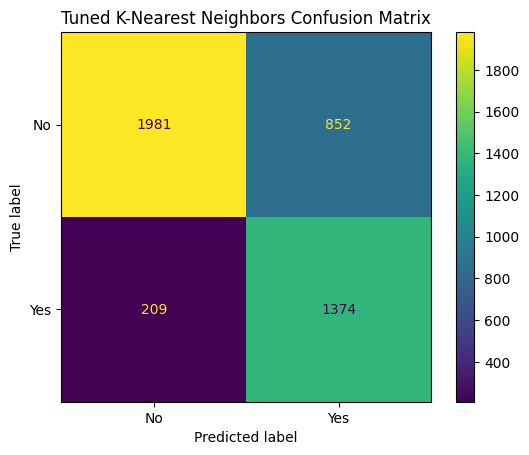

In [51]:
knn_cm = confusion_matrix(y_test, knn_y_pred)

knn_cmd = ConfusionMatrixDisplay(confusion_matrix=lgr_cm, display_labels=tuned_knn.classes_)
fig = knn_cmd.plot().figure_
plt.title('Tuned K-Nearest Neighbors Confusion Matrix')
plt.show()
fig.tight_layout(rect=(0,.05,1,1)) 

In [52]:
tuned_knn_train_time = round(tuned_knn_end_time_ms - tuned_knn_start_time_ms)
tuned_knn_train_score = round(tuned_knn.score(X_train, y_train), 4)
tuned_knn_test_score = round(recall_score(y_test, knn_y_pred, pos_label='Yes'), 4)
printTunedMetrics(tuned_knn_train_time, tuned_knn_train_score, tuned_knn_test_score)

Train Time is 16 ms, Train Recall is 0.7301 , Test Recall is 0.7069


Decision Tree

In [53]:
params =  {'criterion': ["gini", "entropy"],
    'max_depth': [3, 5, 15, 21, 25, None],
    'min_samples_split': [2, 5, 15, 25, 50],
    'min_samples_leaf': [1, 2, 5, 7, 15]
}
tuned_dtc = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=5, scoring=recall_scorer).fit(X_train, y_train)

In [54]:
print(tuned_dtc.best_params_)

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 25}


In [55]:
tuned_dtc_start_time_ms = round(time.time() * 1000) 
tuned_dtc.best_estimator_.fit(X_train, y_train)
tuned_dtc_end_time_ms = round(time.time() * 1000)
dtc_y_pred = tuned_dtc.predict(X_test)

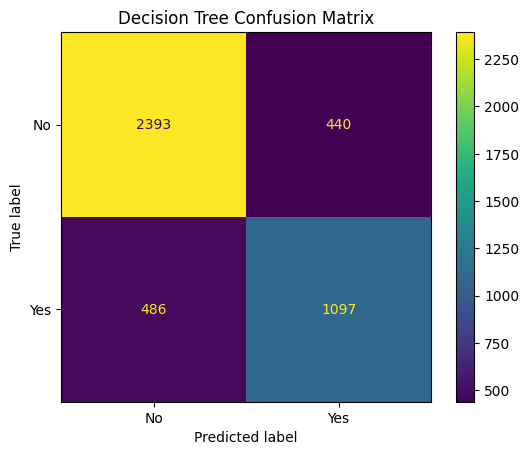

In [56]:
dtc_cm = confusion_matrix(y_test, dtc_y_pred)

dtc_cmd = ConfusionMatrixDisplay(confusion_matrix=dtc_cm, display_labels=tuned_dtc.classes_)
fig = dtc_cmd.plot().figure_
plt.title('Decision Tree Confusion Matrix')
plt.show()
fig.tight_layout(rect=(0,.05,1,1)) 

In [57]:
tuned_dtc_train_time = round(tuned_dtc_end_time_ms - tuned_dtc_start_time_ms)
tuned_dtc_train_score = round(tuned_dtc.score(X_train, y_train), 4)
tuned_dtc_test_score = round(recall_score(y_test, dtc_y_pred, pos_label='Yes'), 4)
printTunedMetrics(tuned_dtc_train_time, tuned_dtc_train_score, tuned_dtc_test_score)

Train Time is 18 ms, Train Recall is 0.7232 , Test Recall is 0.693


Support Vector Classifier

In [58]:
params = [
    {'svc__C': [0.1, 1], 'svc__kernel': ['linear', 'rbf'] },
    {'svc__C': [0.1, 1, 10], 'svc__kernel': ['poly'], 'svc__degree': [2, 3, 4] }
 ]
tuned_svc_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC(random_state=42))])

tuned_svc = GridSearchCV(tuned_svc_pipe, params, return_train_score=True, cv=5, scoring=recall_scorer).fit(X_train, y_train)

In [59]:
print(tuned_svc.best_params_)

{'svc__C': 0.1, 'svc__kernel': 'linear'}


In [60]:
tuned_svc_start_time_ms = round(time.time() * 1000) 
tuned_svc.best_estimator_.fit(X_train, y_train)
tuned_svc_end_time_ms = round(time.time() * 1000)
svc_y_pred = tuned_svc.predict(X_test)

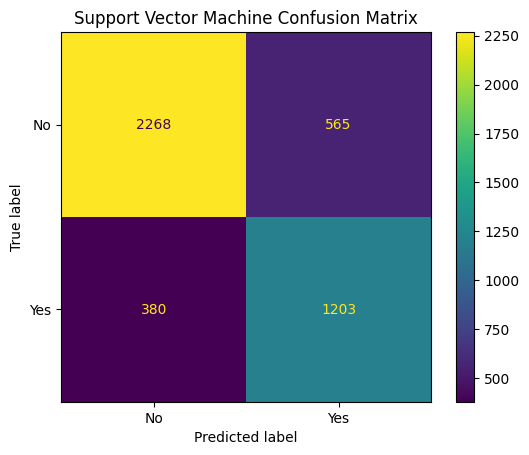

In [61]:
svc_cm = confusion_matrix(y_test, svc_y_pred)

svc_cmd = ConfusionMatrixDisplay(confusion_matrix=svc_cm, display_labels=tuned_svc.classes_)
fig = svc_cmd.plot().figure_
plt.title('Support Vector Machine Confusion Matrix')
plt.show()
fig.tight_layout(rect=(0,.05,1,1)) 

In [62]:
tuned_svc_train_time = round(tuned_svc_end_time_ms - tuned_svc_start_time_ms)
tuned_svc_train_score = round(tuned_svc.score(X_train, y_train), 4)
tuned_svc_test_score = round(recall_score(y_test, svc_y_pred, pos_label='Yes'), 4)
printTunedMetrics(tuned_svc_train_time, tuned_svc_train_score, tuned_svc_test_score)

Train Time is 1318 ms, Train Recall is 0.7333 , Test Recall is 0.7599


Hyperparameter Tuning Results

In [63]:
tuned_results = pd.DataFrame({
    'Train Time (ms)': [tuned_lgr_train_time, tuned_knn_train_time, tuned_dtc_train_time, tuned_svc_train_time],
    'Train Recall': [tuned_lgr_train_score, tuned_knn_train_score, tuned_dtc_train_score, tuned_svc_train_score],
    'Test Recall': [tuned_lgr_test_score, tuned_knn_test_score, tuned_dtc_test_score, tuned_svc_test_score]
}, index=['Logistic Regression','K-Nearest Neighbors','Decision Tree','Support Vector Machine'])
tuned_results

,Train Time (ms),Train Recall,Test Recall
Logistic Regression,14,0.8473,0.8680
K-Nearest Neighbors,16,0.7301,0.7069
Decision Tree,18,0.7232,0.6930
Support Vector Machine,1318,0.7333,0.7599


With hyperparameter tuning, the logistic regression model had the best score.

#### Modeling with Ensamble Techniques

To explore ensamble techniques, a random forest classifier and AdaBoost classifier are selected using grid search. 

In [64]:
params =  {
           'n_estimators': [1, 10, 25, 100, 200],
           'criterion': ["gini", "entropy"],
           'max_depth': [3, 5, 15, None]
          }
gscv_rfc = GridSearchCV(RandomForestClassifier(random_state=42), params, return_train_score=True, cv=5, scoring=recall_scorer).fit(X_train, y_train)

In [65]:
print(gscv_rfc.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 200}


In [66]:
tuned_rfc_start_time_ms = round(time.time() * 1000) 
gscv_rfc.best_estimator_.fit(X_train, y_train)
tuned_rfc_end_time_ms = round(time.time() * 1000)

In [67]:
rfc_y_pred = gscv_rfc.predict(X_test)
tuned_rfc_train_time = round(tuned_rfc_end_time_ms - tuned_rfc_start_time_ms)
tuned_rfc_train_score = round(gscv_rfc.score(X_train, y_train), 4)
tuned_rfc_test_score = round(recall_score(y_test, rfc_y_pred, pos_label='Yes'), 4)
printTunedMetrics(tuned_rfc_train_time, tuned_rfc_train_score, tuned_rfc_test_score)

Train Time is 397 ms, Train Recall is 0.8924 , Test Recall is 0.9015


In [68]:
params = {'abc__estimator__C': [1]}
params = [
  {'abc__estimator__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
   'abc__estimator__penalty': ['l1', 'l2'], 
   'abc__estimator__solver': ['liblinear']
  },
  {'abc__estimator__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
   'abc__estimator__penalty': ['l2'], 
   'abc__estimator__solver': ['lbfgs','newton-cg', 'newton-cholesky'],
  }
 ]
lgr_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('abc', AdaBoostClassifier(estimator=LogisticRegression(), algorithm="SAMME", random_state = 42))])
gscv_abc = GridSearchCV(lgr_pipe, params, return_train_score=True, cv=5, scoring=recall_scorer).fit(X_train, y_train)

In [69]:
print(gscv_abc.best_params_)

{'abc__estimator__C': 10, 'abc__estimator__penalty': 'l1', 'abc__estimator__solver': 'liblinear'}


In [70]:
tuned_abc_start_time_ms = round(time.time() * 1000) 
gscv_abc.best_estimator_.fit(X_train, y_train)
tuned_abc_end_time_ms = round(time.time() * 1000)

In [71]:
abc_y_pred = gscv_abc.predict(X_test)
tuned_abc_train_time = round(tuned_abc_end_time_ms - tuned_abc_start_time_ms)
tuned_abc_train_score = round(gscv_abc.score(X_train, y_train), 4)
tuned_abc_test_score = round(recall_score(y_test, abc_y_pred, pos_label='Yes'), 4)
printTunedMetrics(tuned_abc_train_time, tuned_abc_train_score, tuned_abc_test_score)

Train Time is 499 ms, Train Recall is 0.9116 , Test Recall is 0.9191


Both ensamble techniques performed better than any of the tuned models. The AdaBoost classifier using a logistic regression estimator performed slightly better than the random forest.

## 5. Model Evaluation

### Conclusion and Next Steps

The test scores show that ML modeling is a viable way to predict events when the driver is over the posted speed limit. Ensamble techniques brought the recall score over 0.9. Although this is still too low to use the model as the sole source for identifying speeding, it can used with a speed limit API to reduce error to nearly zero while cutting API costs considerably.

Future work will include model selection, deployment, and testing. We might also be able to interpolate some missing feature data to increase the data set size and make the service more generally useful. As the OSM database becomes more complete, model error should continue to drop. We might eventually be able to use the model as the sole source to find speeders reducing API costs further.